## Finding the percolation packing fraction
### at what min packing fraction do we get percolation

In [1]:
import os
import sys
import glob
import platform
from   tqdm              import tqdm # type: ignore
from   pathlib           import Path
import matplotlib                    # type: ignore
import numpy             as     np   # type: ignore
import matplotlib.pyplot as     plt  # type: ignore
import src.readFiles     as readFiles
import math

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath,bm,type1cm}",
    "font.size": 8,
})

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']


system_platform = platform.system()
if system_platform == 'Darwin':  # macOS
    topDir = Path("/Volumes/rahul_2TB/rigid/mu_inf/")
    figSavePath = Path("/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/peroclation")
elif system_platform == 'Linux':
    topDir = Path("/media/rahul/rahul_2TB/rigid/mu_inf/")
    figSavePath = Path("/home/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/peroclation")
else:
    raise OSError(f"Unsupported OS: {system_platform}")

In [18]:
def kneighborfig(dataname, frame, k=3):
    fig, ax  = plt.subplots(1, 1, figsize=(5,5))
    
    parPath  = glob.glob(f'{dataname}/{parFile}')[0]
    parLines = open(parPath).readlines()

    parList   = readFiles.readParFile(open(parPath))
    intPath   = open(glob.glob(f'{dataname}/{intFile}')[0])
    intList   = readFiles.interactionsList(intPath)
    frameList = intList[frame]

    p1 = frameList[:,0].astype(int)
    p2 = frameList[:,1].astype(int)
    contState = frameList[:,10]

    contMat = np.zeros((npp, npp), dtype=np.uint8)
    mask    = contState == 2
    contMat[p1[mask], p2[mask]] = 1
    contMat[p2[mask], p1[mask]] = 1
    
    px = parList[frame][:, 2]
    pz = parList[frame][:, 3]
    pr = parList[frame][:, 1]
    
    totContacts = contMat.sum(axis=0)
    
    # plotting all particles 
    for i in range(len(px)):
        if totContacts[i] >= k:
            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#A00000', fill=True, edgecolor='none') #083d5f
        else:
            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#8A9BA8', fill=True, edgecolor='none')
        ax.add_artist(circle)
        
    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(fr'$\mathbf{{\phi = {phi},\; \sigma/\sigma_0 = {stress},\; \gamma = {frame/100:.2f},\; k \geq 3}}$',
                 fontsize=16, pad=1, fontweight='bold', x=0.5)
    
def makerigsnapshot(dataname, frame):
    fig, ax  = plt.subplots(1, 1, figsize=(5,5))
    
    if os.path.exists(dataname):
        parPath  = glob.glob(f'{dataname}/{parFile}')[0]
        parLines = open(parPath).readlines()
        parList  = readFiles.readParFile(open(parPath))

        rigFilePath   = glob.glob(f'{dataname}/{rigFile}')
        if not rigFilePath:
            print(f"Error: {rigFile} not found at {dataname}")
            sys.exit(1)
        rigidFile     = open(rigFilePath[0])
        rigClusterIDs = readFiles.rigList(rigidFile)
        clusterIDs    = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in samplelist for num in sublist}) for samplelist in rigClusterIDs]

        # Box dimensions.
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        px = parList[frame][:,2]
        pz = parList[frame][:,3]
        pr = parList[frame][:,1]

        # Setting up axis and box walls.
        #fig, ax = plt.subplots(1, 1, figsize=(1,1), dpi = 500)
        newLx   = Lx + 2*np.max(pr)
        newLz   = Lz + 2*np.max(pr)

        allPart      = parList[frame][:,0]
        rigidPart    = clusterIDs[frame]
        notRigidPart = allPart[np.isin(allPart, rigidPart) == False]

        ax.clear()
        for index in notRigidPart:
            index  = int(index)
            circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='w', edgecolor='k', linewidth=0.25, zorder=1)
            ax.add_artist(circle)
        
        for index in rigidPart:
            circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='#A00000', edgecolor=None, zorder=2)
            ax.add_artist(circle)

        ax.set_xlim([-(newLx/2),(newLx/2)])
        ax.set_ylim([-(newLz/2),(newLz/2)])
        ax.axis('off')
        ax.set_aspect('equal')
        ax.set_title(fr'$\mathbf{{\phi = {phi},\; \sigma/\sigma_0 = {stress},\; \gamma = {frame/100:.2f}}}$', 
                     fontsize=17, pad=1, fontweight='bold', x=0.5)

        #plt.tight_layout()
        
def kclusters(contmatrix, frame, k=3):
    cordination = contMat.sum(axis=1)
    #neighbors   = {i: np.where(contMat[i] == 1)[0] for i in range(contMat.shape[0])}
    knodes      = set(np.where(cordination >= k)[0])
    neighbors   = {i: [j for j in np.where(contMat[i] == 1)[0] 
                   if j in knodes] for i in knodes}
    
    visited  = set()
    clusters = []

    for node in knodes:
        if node not in visited:
            stack = [node]
            cluster = set()

            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    cluster.add(current)
                    stack.extend(neighbors[current])

            clusters.append(cluster)
            
    return clusters

def clusterSpan(positions, box_length):
    ref = positions[0]
    shifted = (positions - ref + box_length/2) % box_length - box_length/2
    return shifted.max() - shifted.min()

In [3]:
## Making kspanning and rig spanning figures for available data

# Simulation parameters
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data'
stress_vals   = ['0.1','0.2','0.5','1','2','5','10','25','50','80','100'] # '0.05', '200','250'
phiv_vals     = [0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8, 0.802, 0.82] #.72
stress_floats = [float(st) for st in stress_vals]

npp    = 1000
ar     = '1.4'
vr     = '0.5'
numRun = 1
off    = 100

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'
rigFile = 'rig_*.dat'

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True

## Plotting the available point inn stress and phi for \selta =1.4
for i, st in enumerate(tqdm(stress_vals)):
    for phi in phiv_vals:
        phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        path = f'{topDir}/flow_curves/stress_{st}r/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_1'
        if os.path.exists(path):
            kspanning   = set()
            rigspanning = set()
            dataname    = path #f"{topDir}/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
            if os.path.exists(dataname):
                parPath  = glob.glob(f'{dataname}/{parFile}')[0]
                parLines = open(parPath).readlines()
                parList  = readFiles.readParFile(open(parPath))
                
                intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
                intList  = readFiles.interactionsList(intPath)
                
                rigFilePath   = glob.glob(f'{dataname}/{rigFile}')
                rigidFile     = open(rigFilePath[0])
                rigClusterIDs = readFiles.rigList(rigidFile)
                
                # box dimensions
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])
            
                newLx = Lx + 2*float(ar)
                newLz = Lz + 2*float(ar)
                
                for frame in range(off, off+300):
                    #frame =1000
                    frameList = intList[frame]
            
                    p1 = frameList[:,0].astype(int)
                    p2 = frameList[:,1].astype(int)
                    contState = frameList[:,10]
            
                    contMat = np.zeros((npp, npp), dtype=np.uint8)
                    mask    = contState == 2
                    contMat[p1[mask], p2[mask]] = 1
                    contMat[p2[mask], p1[mask]] = 1

                    #kneighbors
                    clusters = kclusters(contMat, frame, k=3)
                    
                    for group in clusters:
                        px = parList[frame][list(group), 2]
                        pz = parList[frame][list(group), 3]
                        
                        spanx = clusterSpan(px, Lx)
                        spanz = clusterSpan(pz, Lz)
                        #if spanz >= Lz - float(ar):
                        if spanx >= Lx - float(ar) and spanz >= Lz - float(ar):
                            kspanning.add(frame)
                    
                    #for group in clusterIDs:
                    for rigIDs in rigClusterIDs[frame]:
                        px = parList[frame][rigIDs, 2]
                        pz = parList[frame][rigIDs, 3]
            
                        spanx = clusterSpan(px, Lx)
                        spanz = clusterSpan(pz, Lz)
            
                        if spanx >= Lx - float(ar) and spanz >= Lz - float(ar):
                            rigspanning.add(frame)
            
            datFile = glob.glob(f'{dataname}/data_*.dat')[0]
            data    = np.loadtxt(open(datFile))
            visc    = data[off:off+300, 3]
            strain  = data[off:off+300, 1]
            
            # Plotting kspanning figures
            plt.plot(strain, visc/np.mean(visc), color='darkblue', linestyle='--', linewidth=1)
            plt.scatter(np.array(list(kspanning))/100, np.ones(len(list(kspanning))), color='red', s=10,
                       label='spanning k3 clusters') #rig clusters
            
            plt.legend(fontsize=14, markerscale=2.0,)
            plt.xlabel(r'$\mathbf{t \dot \gamma_0}$',fontsize=14)
            plt.ylabel(r'$\mathbf{\eta_r/\langle \eta_r \rangle}$',fontsize=14)
            plt.title(rf"$\mathbf{{\sigma/\sigma_0 = {st}, \; \phi = {phi}, \; \delta = {ar}}}$", fontsize=18)
            #plt.yscale('log')
            plt.ylim([0, 3])
            plt.savefig(f'{figSavePath}/kSpanning/k3_spanning_stress_{st}_phi_{phi}_ar_{ar}.pdf', dpi=400)
            plt.close()
            
            # Plotting rig spanning figure
            plt.plot(strain, visc/np.mean(visc), color='darkblue', linestyle='--', linewidth=1)
            plt.scatter(np.array(list(rigspanning))/100, np.ones(len(list(rigspanning))), color='red', s=10,
                       label='spanning rig clusters') #rig clusters
            
            plt.legend(fontsize=14, markerscale=2.0,)
            plt.xlabel(r'$\mathbf{t \dot \gamma_0}$',fontsize=14)
            plt.ylabel(r'$\mathbf{\eta_r/\langle \eta_r \rangle}$',fontsize=14)
            plt.title(rf"$\mathbf{{\sigma/\sigma_0 = {st}, \; \phi = {phi}, \; \delta = {ar}}}$", fontsize=18)
            #plt.yscale('log')
            plt.ylim([0, 3])
            plt.savefig(f'{figSavePath}/rigSpanning/rig_spanning_phi_stress_{st}_{phi}_ar_{ar}.pdf', dpi=400)
            plt.close()

100%|███████████████████████████████████████████| 11/11 [02:29<00:00, 13.57s/it]


In [20]:
## Making snapshots for k-neighbor particles
# Simulation parameters
import itertools

npp        = 1000
phi        = '0.765' #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar         = 1.4  #, 1.4, 1.8, 2.0, 4.0]
vr         = '0.5'
stressvals = ['2', '5', '10']
numRun     = 1
off        = 100

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'
rigFile = 'rig_*.dat'

# plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
# plt.rcParams["figure.autolayout"]   = True

# Frame details
startFrame = off
endFrame   = 201

kspanning   = set()
rigspanning = set()

frames = range(startFrame, endFrame)

for stress, frame in tqdm(itertools.product(stressvals, frames), total=len(stressvals) * len(frames)):
#for stress in stressvals:
    dataname = f"{topDir}/flow_curves/stress_{stress}r/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
    if os.path.exists(dataname):
        parPath  = glob.glob(f'{dataname}/{parFile}')[0]
        parLines = open(parPath).readlines()
        parList  = readFiles.readParFile(open(parPath))

        intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
        intList  = readFiles.interactionsList(intPath)

        rigFilePath   = glob.glob(f'{dataname}/{rigFile}')
        rigidFile     = open(rigFilePath[0])
        rigClusterIDs = readFiles.rigList(rigidFile)

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        newLx = Lx + 2*ar
        newLz = Lz + 2*ar

        #for frame in tqdm(range(startFrame, endFrame), desc="Processing frames"):
        #frame =1000
        frameList = intList[frame]

        p1 = frameList[:,0].astype(int)
        p2 = frameList[:,1].astype(int)
        contState = frameList[:,10]

        contMat = np.zeros((npp, npp), dtype=np.uint8)
        mask    = contState == 2
        contMat[p1[mask], p2[mask]] = 1
        contMat[p2[mask], p1[mask]] = 1

        clusters = kclusters(contMat, frame, k=3)

        for group in clusters:
            px = parList[frame][list(group), 2]
            pz = parList[frame][list(group), 3]

            spanx = clusterSpan(px, Lx)
            spanz = clusterSpan(pz, Lz)
            #if spanz >= Lz - ar:
            if spanx >= Lx - ar and spanz >= Lz - ar:
                kspanning.add(frame)

        kneighborfig(dataname, frame, k=3)
        directory = f'{figSavePath}/snapshots/stress_{stress}_phi_{phi}_kneigh'
        os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{directory}/{frame}.png', dpi=150)
        plt.close()

#         #for group in clusterIDs:
#         for rigIDs in rigClusterIDs[frame]:
#             px = parList[frame][rigIDs, 2]
#             pz = parList[frame][rigIDs, 3]

#             spanx = clusterSpan(px, Lx)
#             spanz = clusterSpan(pz, Lz)

#             if spanx >= Lx - ar and spanz >= Lz - ar:
#                 rigspanning.add(frame)

#         makerigsnapshot(dataname, frame)
#         directory = f'{figSavePath}/snapshots/stress_{stress}_phi_{phi}_rig'
#         os.makedirs(directory, exist_ok=True)
#         plt.savefig(f'{directory}/{frame}.png', dpi=150)
#         plt.close()

100%|███████████████████████████████████████| 303/303 [1:41:46<00:00, 20.15s/it]


<Figure size 640x480 with 0 Axes>

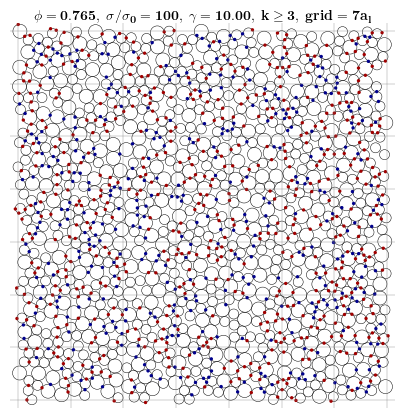

In [194]:
## plotting contact points

npp        = 1000
phi        = '0.765' #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar         = 1.4  #, 1.4, 1.8, 2.0, 4.0]
vr         = '0.5'
numRun     = 1
off        = 100

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'

stress = '100'
dataname = f"{topDir}/flow_curves/stress_{stress}r/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
if os.path.exists(dataname):
    parPath  = glob.glob(f'{dataname}/{parFile}')[0]
    parLines = open(parPath).readlines()
    parList  = readFiles.readParFile(open(parPath))

    intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
    intList  = readFiles.interactionsList(intPath)
    
    # box dimensions
    Lx = float(parLines[3].split()[2]) 
    Lz = float(parLines[3].split()[2])
    
    newLx = Lx + 2*ar
    newLz = Lz + 2*ar
        
    lx_spaced = np.linspace(-Lx, Lx, 100)
    lz_spaced = np.linspace(-Lx, Lx, 100)

    #for frame in tqdm(range(startFrame, endFrame), desc="Processing frames"):
    frame =1000
    frameList = intList[frame]

    p1 = frameList[:,0].astype(int)
    p2 = frameList[:,1].astype(int)
    cx = frameList[:,2] # contact vector
    cz = frameList[:,4]
    contState = frameList[:,10]

    #fricContacts = contState.count(2)

    pidx = parList[frame][:, 1]
    pr  = parList[frame][:, 1]
    #p2r  = parList[frame][:, 1]
    px   = parList[frame][:, 2]
    pz   = parList[frame][:, 3]

    g = parList[frame][:, 5] #dimensionless overlap

    contPoints = np.zeros([len(pr), 3])
    contColor  = len(pr)*['#A00000']
    
    for ii in range(len(pr)):
        pidx1 = p1[ii]
        pidx2 = p2[ii]
        
        if contState[ii] == 2:
            gap = g[pidx1] * (pr[pidx1] + pr[pidx2])/2
            d   = pr[pidx1] + gap/2
        else:
            d = np.sqrt((px[pidx2] - px[pidx1])**2 + (pz[pidx2] - pz[pidx1])**2)/2
            contColor[ii] = '#00008B'
            
        #contact points
        px2 = px[pidx1] + d * cx[ii]
        pz2 = pz[pidx1] + d * cz[ii]
        contPoints[ii, :] = px2, pz2, contState[ii]

plt.clf()
fig, ax  = plt.subplots(1, 1, figsize=(5,5))

# plotting all particles 
for i in range(len(px)):
    circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='None', fill=False, 
                        edgecolor='k', lw=0.35)
    ax.add_artist(circle)
        
    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
    ax.axis('off')
    ax.set_aspect('equal')
    
    
#mask = contPoints[:, 2] == 2  
#plt.scatter(contPoints[:,0][mask], contPoints[:,1][mask], color='#A00000', s =3)
plt.scatter(contPoints[:,0], contPoints[:,1], color=contColor, s=2)


# Mesh (edges)
gridSize = 7
nxz      = int(Lx/gridSize/ar)
lx_edges = np.linspace(-Lx/2, Lx/2, nxz+1)  # +1 because edges
lz_edges = np.linspace(-Lz/2, Lz/2, nxz+1)

for x in lx_edges:
    ax.axvline(x=x, color='gray', linestyle='-', lw = 0.3, alpha=0.9)

# Horizontal lines at each z-edge
for z in lz_edges:
    ax.axhline(y=z, color='gray', linestyle='-', lw = 0.3, alpha=0.9)

ax.set_title(fr'$\mathbf{{\phi = {phi},\; \sigma/\sigma_0 = {stress},\; \gamma = {frame/100:.2f},\; k \geq 3, \; grid = {gridSize}a_l}}$',
                 fontsize=10, pad=1, fontweight='bold', x=0.5)
plt.savefig(f'{figSavePath}/contPoints_stress_{stress}_grid_{gridSize}_frame_{frame}.png', dpi=250, bbox_inches='tight')

plt.show()

In [182]:
int(Lx/(gridSize*ar))

7

In [180]:
(lx_edges[1] - lx_edges[0])/1.4

np.float64(3.762795918367346)

In [178]:
Lx

73.7508

In [69]:
## box averaging over just k3 particles
# Varying stress, fixed gridsize

npp      =  1000
phi      = '0.765' #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar       =  1.4  #, 1.4, 1.8, 2.0, 4.0]
vr       = '0.5'
stresses = ['1', '2', '5', '10','100']
numRun   = 1
off      = 100
gridsize = 5 #grid_size

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'

allMeshDensity = {k: [] for k in stresses}

for stress in stresses:
    dataname = f"{topDir}/flow_curves/stress_{stress}r/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
    if os.path.exists(dataname):
        #print(dataname)
        parPath  = glob.glob(f'{dataname}/{parFile}')[0]
        parLines = open(parPath).readlines()
        parList  = readFiles.readParFile(open(parPath))

        intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
        intList  = readFiles.interactionsList(intPath)

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        for frame in tqdm(range(off, len(parList))):
            frameList = intList[frame]

            p1 = frameList[:,0].astype(int)
            p2 = frameList[:,1].astype(int)
            contState = frameList[:,10]

            contMat = np.zeros((npp, npp), dtype=np.uint8)
            mask    = contState == 2
            contMat[p1[mask], p2[mask]] = 1
            contMat[p2[mask], p1[mask]] = 1

            # particle positions
            px = parList[frame][:, 2]
            pz = parList[frame][:, 3]

            clusters = kclusters(contMat, frame, k=3)
            k3idx    = set(int(x) for s in clusters for x in s)


            # Mesh (edges)
            nxz      = int(Lx/gridsize/ar)
            lx_edges = np.linspace(-Lx/2, Lx/2, nxz+1)  # +1 because edges
            lz_edges = np.linspace(-Lz/2, Lz/2, nxz+1)

            countsk3, x_edges, z_edges = np.histogram2d(px[np.fromiter(k3idx, dtype=int)],
                                                        pz[np.fromiter(k3idx, dtype=int)], 
                                                        bins=[lx_edges, lz_edges])

            dx = x_edges[1] - x_edges[0]
            dz = z_edges[1] - z_edges[0]
            mesh_area = dx * dz

            density  = countsk3 /mesh_area
            allMeshDensity[stress].extend(density.flatten().tolist())

100%|██████████████████████████████████████| 1101/1101 [00:01<00:00, 739.72it/s]


In [70]:
gridsize

5

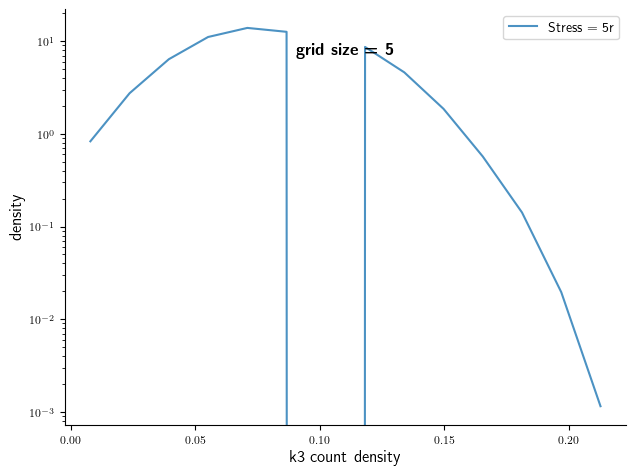

In [71]:
## For density with k3 particle count density; varying stress

plt.figure()

for ii, stress in enumerate(stresses):
    dataset = allMeshDensity[stress]
    #bins = np.arange(min(dataset), max(dataset))
    counts, bin_edges = np.histogram(dataset, bins=14, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, counts, linestyle='-', alpha=0.8, markersize=3,
             label=f'Stress = {stress}r', zorder=ii)

ax = plt.gca()

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])

# Set y-axis label only
ax.set_ylabel("density", fontsize=12)
ax.set_xlabel("k3 count density", fontsize=12)
#ax.set_xlim(0, 1.5)
ax.set_yscale('log')
ax.text(0.5, 0.9, rf'$\textbf{{grid size = {gridsize}}}$', transform=ax.transAxes,
        fontsize=12, color='k', ha='center', va='center')

#plt.xticks(np.arange(0, 21, 3))
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f'{figSavePath}/k3countHist_grid_{gridsize}.png', 
            dpi=250, bbox_inches='tight')
plt.show()

In [52]:
allMeshDensity['5']

[0.07445974627103213,
 0.09431567860997404,
 0.09100635655348373,
 0.09762500066646436,
 0.08604237346874824,
 0.08935169552523857,
 0.07942372935576761,
 0.07942372935576761,
 0.06949576318629666,
 0.06949576318629666,
 0.07942372935576761,
 0.07776906832752245,
 0.08935169552523857,
 0.09100635655348373,
 0.07611440729927729,
 0.07445974627103213,
 0.08107839038401277,
 0.06122245804507087,
 0.06618644112980634,
 0.07611440729927729,
 0.06949576318629666,
 0.08438771244050308,
 0.07776906832752245,
 0.08438771244050308,
 0.07445974627103213,
 0.08107839038401277,
 0.052949152903845075,
 0.06453178010156119,
 0.08604237346874824,
 0.06287711907331603,
 0.07942372935576761,
 0.07445974627103213,
 0.08107839038401277,
 0.07611440729927729,
 0.08438771244050308,
 0.052949152903845075,
 0.06618644112980634,
 0.09100635655348373,
 0.07115042421454182,
 0.07776906832752245,
 0.07776906832752245,
 0.08107839038401277,
 0.07611440729927729,
 0.07942372935576761,
 0.052949152903845075,
 0.0661

In [41]:
## box averaging over just k3 particles
# Varying box size

npp      =  1000
phi      = '0.765' #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar       =  1.4  #, 1.4, 1.8, 2.0, 4.0]
vr       = '0.5'
stress   = '2'
numRun   = 1
off      = 100
gSize    = [2, 3, 4, 5, 7, 14] #grid_size

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'

allMeshDensity = {k: [] for k in gSize}

dataname = f"{topDir}/flow_curves/stress_{stress}r/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
if os.path.exists(dataname):
    #print(dataname)
    parPath  = glob.glob(f'{dataname}/{parFile}')[0]
    parLines = open(parPath).readlines()
    parList  = readFiles.readParFile(open(parPath))

    intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
    intList  = readFiles.interactionsList(intPath)

    # box dimensions
    Lx = float(parLines[3].split()[2]) 
    Lz = float(parLines[3].split()[2])

    for frame in tqdm(range(off, len(parList))):
        frameList = intList[frame]

        p1 = frameList[:,0].astype(int)
        p2 = frameList[:,1].astype(int)
        contState = frameList[:,10]

        contMat = np.zeros((npp, npp), dtype=np.uint8)
        mask    = contState == 2
        contMat[p1[mask], p2[mask]] = 1
        contMat[p2[mask], p1[mask]] = 1
        
        # particle positions
        px = parList[frame][:, 2]
        pz = parList[frame][:, 3]
            
        clusters = kclusters(contMat, frame, k=3)
        k3idx    = set(int(x) for s in clusters for x in s)
        
        for gridSize in gSize:
            # Mesh (edges)
            nxz      = int(Lx/gridSize/ar)
            lx_edges = np.linspace(-Lx/2, Lx/2, nxz+1)  # +1 because edges
            lz_edges = np.linspace(-Lz/2, Lz/2, nxz+1)

            countsk3, x_edges, z_edges = np.histogram2d(px[np.fromiter(k3idx, dtype=int)],
                                                        pz[np.fromiter(k3idx, dtype=int)], 
                                                        bins=[lx_edges, lz_edges])
            
            dx = x_edges[1] - x_edges[0]
            dz = z_edges[1] - z_edges[0]
            mesh_area = dx * dz

            density  = countsk3
            allMeshDensity[gridSize].extend(density.flatten().tolist())

100%|█████████████████████████████████████| 1101/1101 [00:01<00:00, 1033.31it/s]


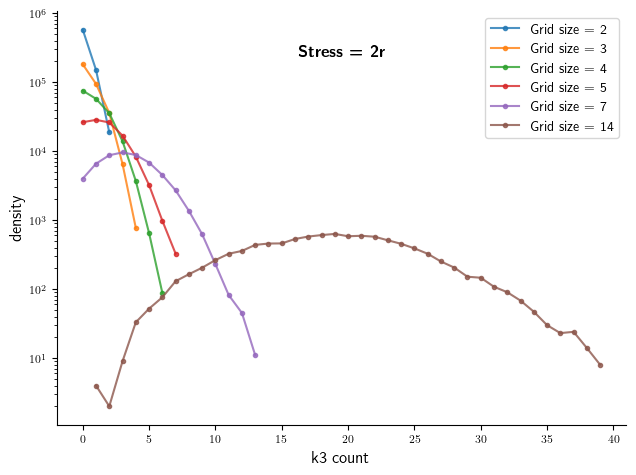

In [42]:
## For density with k3 particle count

plt.figure()

for ii, gridsize in enumerate(gSize):
    dataset = allMeshDensity[gridsize]
    bins = np.arange(min(dataset), max(dataset))
    counts, bin_edges = np.histogram(dataset, bins=bins)
    #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_edges[:-1], counts, marker='o', alpha=0.8, markersize=3,
             label=f'Grid size = {gridsize}', zorder=ii)

ax = plt.gca()

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])

# Set y-axis label only
ax.set_ylabel("density", fontsize=12)
ax.set_xlabel("k3 count", fontsize=12)
#ax.set_xlim(0, 1.5)
ax.set_yscale('log')
ax.text(0.5, 0.9, rf'$\textbf{{Stress = {stress}r}}$', transform=ax.transAxes,
        fontsize=12, color='k', ha='center', va='center')

#plt.xticks(np.arange(0, 21, 3))
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f'{figSavePath}/k3countHist_stress_{stress}.png', 
            dpi=250, bbox_inches='tight')
plt.show()

In [ ]:
## box averaging over contact points
# Varying phi values

npp      =  1000
phis     = ['0.72', '0.73', '0.74', '0.75'] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar       =  1.4  #, 1.4, 1.8, 2.0, 4.0]
vr       = '0.5'
stress   = '100'
numRun   = 1
off      = 100
gSize    = 5 #grid_size

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'

allMeshDensity = {k: [] for k in phis}

for phi in phis:
    dataname = f"{topDir}/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
    if os.path.exists(dataname):
        #print(dataname)
        parPath  = glob.glob(f'{dataname}/{parFile}')[0]
        parLines = open(parPath).readlines()
        parList  = readFiles.readParFile(open(parPath))

        intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
        intList  = readFiles.interactionsList(intPath)

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        for frame in tqdm(range(off, len(parList))):
            #frame = 1000
            p1 = intList[frame][:,0].astype(int)
            p2 = intList[frame][:,1].astype(int)
            cx = intList[frame][:,2] # contact vector
            cz = intList[frame][:,4]
            contState = intList[frame][:,10]

            pidx = parList[frame][:, 1]
            pr   = parList[frame][:, 1]
            px   = parList[frame][:, 2]
            pz   = parList[frame][:, 3]

            g = parList[frame][:, 5] #dimensionless overlap

            contPoints = np.zeros([len(pr), 3])

            for ii in range(len(pr)):
                pidx1 = p1[ii]
                pidx2 = p2[ii]

                gap = g[pidx1] * (pr[pidx1] + pr[pidx2])/2
                d   = pr[pidx1] + gap/2

                #contact points
                px2 = px[pidx1] + d * cx[ii]
                pz2 = pz[pidx1] + d * cz[ii]

                contPoints[ii, :] = px2, pz2, contState[ii]

            ## Considering only frictional points
            mask = contPoints[:, 2] == 2
            contPointx = contPoints[:, 0][mask]
            contPointz = contPoints[:, 1][mask]

            
            # Mesh (edges)
            nxz = int(Lx/gSize/ar)
            lx_edges  = np.linspace(-Lx/2, Lx/2, nxz+1)  # +1 because edges
            lz_edges  = np.linspace(-Lz/2, Lz/2, nxz+1)

            #Histogram
            counts,  x_edges, z_edges = np.histogram2d(contPointx, contPointz, bins=[lx_edges, lz_edges])
            countsp, x_edges, z_edges = np.histogram2d(px, pz, bins=[lx_edges, lz_edges])

            dx = x_edges[1] - x_edges[0]
            dz = z_edges[1] - z_edges[0]
            mesh_area = dx * dz

            # handeling 0 counts in mesh
            counts  = np.array(counts)
            countsp = np.array(countsp)
            mask    = countsp != 0
            counts_ = counts[mask]
            countsp_= countsp[mask]

            density = counts#_ / countsp_ #/ mesh_area
            allMeshDensity[phi].extend(density.flatten().tolist())

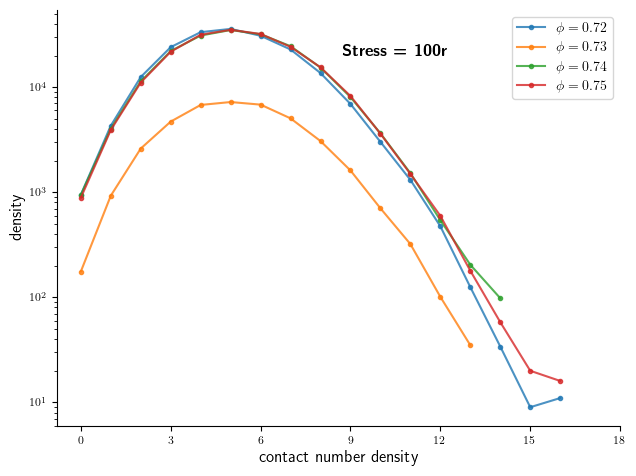

In [12]:
## For density with just number density

plt.figure()

for ii, phi in enumerate(phis):
    dataset = allMeshDensity[phi]
    bins = np.arange(min(dataset), max(dataset))
    counts, bin_edges = np.histogram(dataset, bins=bins)
    #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_edges[:-1], counts, marker='o', alpha=0.8, markersize=3,
             label=fr'$\phi = {phi}$', zorder=ii)

ax = plt.gca()

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])

# Set y-axis label only
ax.set_ylabel("density", fontsize=12)
ax.set_xlabel("contact number density", fontsize=12)
#ax.set_xlim(0, 1.5)
ax.set_yscale('log')
ax.text(0.6, 0.9, rf'$\textbf{{Stress = {stress}r}}$', transform=ax.transAxes,
        fontsize=12, color='k', ha='center', va='center')

plt.xticks(np.arange(0, 21, 3))
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f'{figSavePath}/contPointsDensityHist_phi_stress_{stress}.png', 
            dpi=250, bbox_inches='tight')
plt.show()

In [13]:
## box averaging over contact points
# Varying box size

npp      =  1000
phi      = '0.765' #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar       =  1.4  #, 1.4, 1.8, 2.0, 4.0]
vr       = '0.5'
stress   = '2'
numRun   = 1
off      = 100
gSize    = [2, 3, 4, 5, 7, 14] #grid_size

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'

allMeshDensity = {k: [] for k in gSize}

dataname = f"{topDir}/flow_curves/stress_{stress}r/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
if os.path.exists(dataname):
    #print(dataname)
    parPath  = glob.glob(f'{dataname}/{parFile}')[0]
    parLines = open(parPath).readlines()
    parList  = readFiles.readParFile(open(parPath))

    intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
    intList  = readFiles.interactionsList(intPath)

    # box dimensions
    Lx = float(parLines[3].split()[2]) 
    Lz = float(parLines[3].split()[2])

    for frame in tqdm(range(off, len(parList))):
        #frame = 1000
        p1 = intList[frame][:,0].astype(int)
        p2 = intList[frame][:,1].astype(int)
        cx = intList[frame][:,2] # contact vector
        cz = intList[frame][:,4]
        contState = intList[frame][:,10]

        pidx = parList[frame][:, 1]
        pr   = parList[frame][:, 1]
        px   = parList[frame][:, 2]
        pz   = parList[frame][:, 3]

        g = parList[frame][:, 5] #dimensionless overlap

        contPoints = np.zeros([len(pr), 3])

        for ii in range(len(pr)):
            pidx1 = p1[ii]
            pidx2 = p2[ii]

            gap = g[pidx1] * (pr[pidx1] + pr[pidx2])/2
            d   = pr[pidx1] + gap/2

            #contact points
            px2 = px[pidx1] + d * cx[ii]
            pz2 = pz[pidx1] + d * cz[ii]

            contPoints[ii, :] = px2, pz2, contState[ii]

        ## Considering only frictional points
        mask = contPoints[:, 2] == 2
        contPointx = contPoints[:, 0][mask]
        contPointz = contPoints[:, 1][mask]

        for gridSize in gSize:
            # Mesh (edges)
            nxz = int(Lx/gridSize/ar)
            lx_edges  = np.linspace(-Lx/2, Lx/2, nxz+1)  # +1 because edges
            lz_edges  = np.linspace(-Lz/2, Lz/2, nxz+1)

            #Histogram
            counts,  x_edges, z_edges = np.histogram2d(contPointx, contPointz, bins=[lx_edges, lz_edges])
            countsp, x_edges, z_edges = np.histogram2d(px, pz, bins=[lx_edges, lz_edges])
            
            dx = x_edges[1] - x_edges[0]
            dz = z_edges[1] - z_edges[0]
            mesh_area = dx * dz
            
            # handeling 0 counts in mesh
            counts  = np.array(counts)
            countsp = np.array(countsp)
            mask    = countsp != 0
            counts_ = counts[mask]
            countsp_= countsp[mask]

            density = counts_ / countsp_ #/ mesh_area
            allMeshDensity[gridSize].extend(density.flatten().tolist())

100%|██████████████████████████████████████| 1101/1101 [00:02<00:00, 522.82it/s]


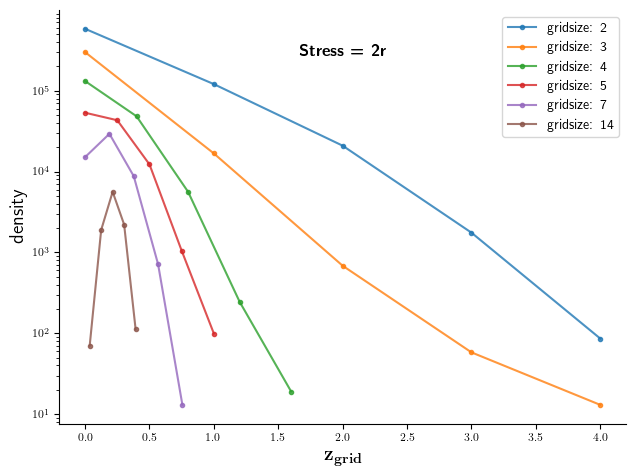

In [14]:
## For density with number count/ number of particles in mesh

plt.figure()

for gridsize in gSize:
    dataset = allMeshDensity[gridsize]
    #bins = np.arange(min(dataset), max(dataset))
    counts, bin_edges = np.histogram(dataset, bins=5)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_edges[:-1], counts, marker='o', alpha=0.8, markersize=3,
             label=f'gridsize: {gridsize}', zorder=gridsize)

ax = plt.gca()

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])

# Set y-axis label only
ax.set_ylabel("density", fontsize=14)
ax.set_xlabel(r'$\mathbf{z_{grid}}$', fontsize=14)
#ax.set_xlim(0, 1.5)
ax.set_yscale('log')
ax.text(0.5, 0.9, rf'$\textbf{{Stress = {stress}r}}$', transform=ax.transAxes,
        fontsize=12, color='k', ha='center', va='center')

#plt.xticks(np.arange(0, 21, 3))
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f'{figSavePath}/contPointsDensityHist_stress_{stress}_.png', 
            dpi=250, bbox_inches='tight')
plt.show()

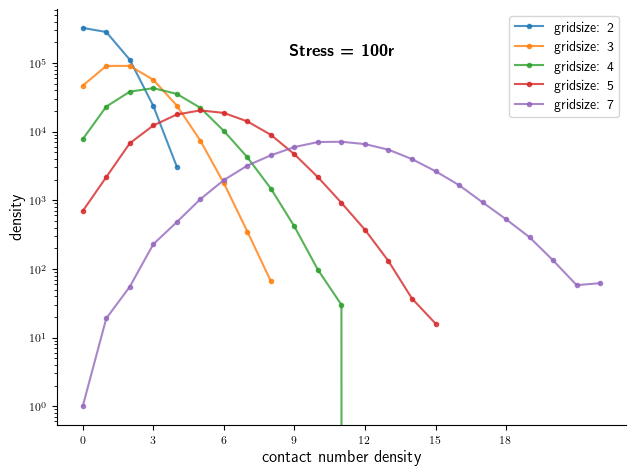

In [11]:
## For density with just number density

plt.figure()

for gridsize in gSize:
    dataset = allMeshDensity[gridsize]
    bins = np.arange(min(dataset), max(dataset))
    counts, bin_edges = np.histogram(dataset, bins=bins)
    #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_edges[:-1], counts, marker='o', alpha=0.8, markersize=3,
             label=f'gridsize: {gridsize}', zorder=gridsize)

ax = plt.gca()

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])

# Set y-axis label only
ax.set_ylabel("density", fontsize=12)
ax.set_xlabel("contact number density", fontsize=12)
#ax.set_xlim(0, 1.5)
ax.set_yscale('log')
ax.text(0.5, 0.9, rf'$\textbf{{Stress = {stress}r}}$', transform=ax.transAxes,
        fontsize=12, color='k', ha='center', va='center')

plt.xticks(np.arange(0, 21, 3))
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f'{figSavePath}/contPointsDensityHist_stress_{stress}.png', 
            dpi=250, bbox_inches='tight')
plt.show()

In [18]:
allMeshDensity[4].count(12)

0

In [212]:
bin_centers

array([0.5, 1.5, 2.5, 3.5, 4.5])

In [46]:
## Making a z plot (stress)

npp      =  1000
phi      = '0.765' #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar       =  1.4  #, 1.4, 1.8, 2.0, 4.0]
vr       = '0.5'
stresses = ['0.1','0.2','0.5', '1', '2', '5', '10', '25', '50', '100', '200']
numRun   = 1
off      = 100

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'

z_all      = []
stress_all = []

for stress in stresses:
    dataname = f"{topDir}/flow_curves/stress_{stress}r/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
    if os.path.exists(dataname):
        #print(dataname)
        parPath  = glob.glob(f'{dataname}/{parFile}')[0]
        parLines = open(parPath).readlines()
        parList  = readFiles.readParFile(open(parPath))

        intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
        intList  = readFiles.interactionsList(intPath)

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])
        
        allInt    = np.vstack(intList[off:])
        contState = allInt[:, 10]
        mask      = contState==2
        z         = sum(mask)/len(intList[off:])/npp
        
        z_all.append(z)
        stress_all.append(float(stress))

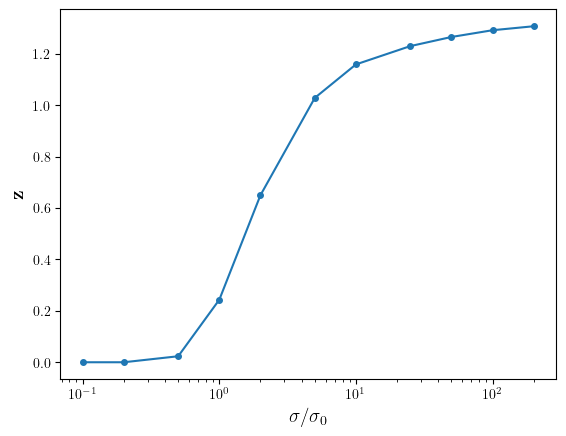

In [47]:
plt.plot(stress_all, z_all, marker='o', lw=1.5, markersize=4)
plt.xlabel(r'$\rm{\sigma/\sigma_0}$', fontsize=14)
plt.ylabel(r'$\mathbf{z}$', fontsize=14)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.xscale('log')
plt.savefig(f'{figSavePath}/zplot_stress.pdf', dpi=250, bbox_inches='tight')

In [19]:
contState = intList[frame][:,10]

In [28]:
intList[1].shape

(2455, 17)

In [29]:
np.vstack(intList).shape

(2866018, 17)

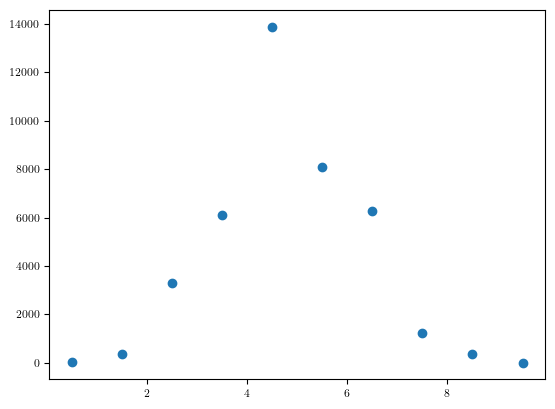

In [172]:
## SImple hist from data
count, bins = np.histogram(allMeshDensity[], bins=10)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.scatter(bin_centers, counts)

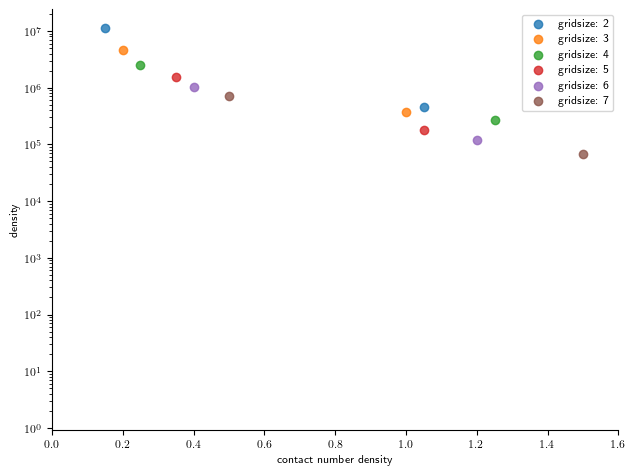

In [86]:
plt.figure()
# for gridsize in gSize:
# #gridsize = 2
#     plt.hist(allMeshDensity[gridSize], bins=10, alpha=0.5, #range=(0, 0.5)
#          label=f'gridsize: {gridsize}', zorder=-gridsize)

for gridsize in gSize:
    counts, bins = np.histogram(allMeshDensity[gridsize], bins=10) #,range=(0. 0.5)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.scatter(bin_centers, counts, alpha=0.8, label=f'gridsize: {gridsize}', zorder=-gridsize)

ax = plt.gca()

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hide y-axis ticks and tick labels
ax.set_yticks([])

# Set y-axis label only
ax.set_ylabel("density")
ax.set_xlabel("contact number density")
ax.set_xlim(0, 1.6)
ax.set_yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

<Figure size 960x720 with 0 Axes>

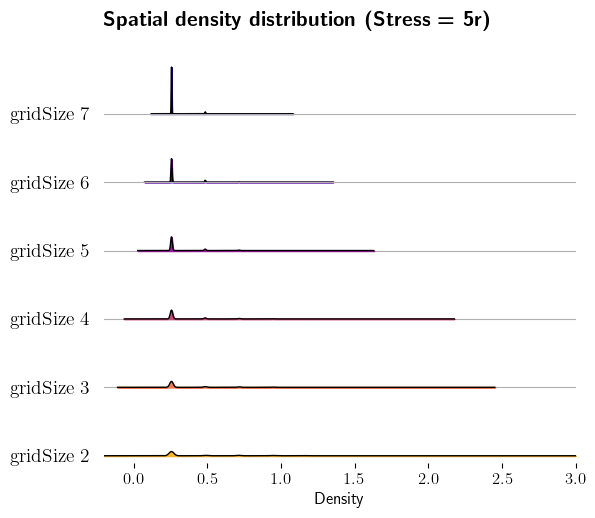

In [31]:
# Source - adapted from https://stackoverflow.com/a
# License - CC BY-SA 4.0

import joypy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

# Convert dictionary to long-format DataFrame
df_list = []
for grid_size, values in allMeshDensity.items():
    df_list.append(pd.DataFrame({'Density': values, 'gSize': grid_size}))

df = pd.concat(df_list, ignore_index=True)

# Convert stress strings to numeric for sorting
df['GridSize'] = df['gSize'].astype(float)

# Sort descending and create labels in LaTeX format
grid_order = sorted(df['GridSize'].unique(), reverse=True)
label_map = {s: rf"$\mathrm{{grid size}} \; {{{int(s)}}}$" for s in grid_order}

# Map numeric stress to LaTeX labels
df['GridLabel'] = df['GridSize'].map(label_map)

# Ensure the labels are in the correct order
labels_ordered = [label_map[s] for s in grid_order]

# Create a high-DPI figure for crisp display
plt.figure(dpi=150)  # increase dpi for clear Jupyter view

fig, axes = joypy.joyplot(
    df,
    by="GridLabel",
    column="Density",
    labels=labels_ordered,
    range_style='own',
    grid="y",
    linewidth=1,
    legend=False,
    figsize=(6,5),
    colormap=cm.plasma,
    overlap=0.2
)

# Set title using Matplotlib
fig.suptitle(
    r"$\textbf{Spatial density distribution (Stress = 5r)}$",
    fontsize=15,     # title font size
    fontweight='bold', # bold text
    y=1.02            # move slightly above the plot
)

# Set y-axis tick label size
for ax in fig.axes:
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')
    for tick in ax.get_xticklabels():
        tick.set_fontsize(12)
        tick.set_fontweight('bold')
    
# Set x-axis limits
plt.xlim(-0.2, 3)
plt.xlabel("Density", fontsize=12)

xticks = np.arange(0, 3.1, 0.5)   # choose spacing you want
plt.xticks(xticks, fontsize=12, fontweight='bold')

plt.ylabel("")  # no y-label because labels are on y-axis
plt.tight_layout()
#plt.savefig(f'{figSavePath}/contPoints_density_stress_{stress}_.png', dpi=250, bbox_inches='tight')
plt.show()

In [56]:
## box averaging over contact points
# Varying stress

npp        = 1000
phi        = '0.765' #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar         = 1.4  #, 1.4, 1.8, 2.0, 4.0]
vr         = '0.5'
stressvals = ['2', '5', '10', '100']
numRun     = 1
off        = 100

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'

allMeshDensity = {k: None for k in stressvals}

for stress in tqdm(stressvals, total=len(stressvals)):
    contDensity = []
    dataname = f"{topDir}/flow_curves/stress_{stress}r/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
    if os.path.exists(dataname):
        parPath  = glob.glob(f'{dataname}/{parFile}')[0]
        parLines = open(parPath).readlines()
        parList  = readFiles.readParFile(open(parPath))

        intPath  = open(glob.glob(f'{dataname}/{intFile}')[0])
        intList  = readFiles.interactionsList(intPath)

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        # Mesh (edges)
        nxz = 15
        lx_edges  = np.linspace(-Lx, Lx, nxz+1)  # +1 because edges
        lz_edges  = np.linspace(-Lz, Lz, nxz+1)
        lx_spaced = np.linspace(-Lx, Lx, 100)
        lz_spaced = np.linspace(-Lx, Lx, 100)

        for frame in range(off, len(parList)):
            #frame = 1000
            
            p1 = intList[frame][:,0].astype(int)
            p2 = intList[frame][:,1].astype(int)
            cx = intList[frame][:,2] # contact vector
            cz = intList[frame][:,4]
            contState = intList[frame][:,10]

            pidx = parList[frame][:, 1]
            pr   = parList[frame][:, 1]
            px   = parList[frame][:, 2]
            pz   = parList[frame][:, 3]

            g = parList[frame][:, 5] #dimensionless overlap

            contPoints = np.zeros([len(pr), 3])

            for ii in range(len(pr)):
                pidx1 = p1[ii]
                pidx2 = p2[ii]

                gap = g[pidx1] * (pr[pidx1] + pr[pidx2])/2
                d   = pr[pidx1] + gap/2

                #contact points
                px2 = px[pidx1] + d * cx[ii]
                pz2 = pz[pidx1] + d * cz[ii]

                contPoints[ii, :] = px2, pz2, contState[ii]

            mask = contPoints[:, 2] == 2
            contPointx = contPoints[:, 0][mask]
            contPointz = contPoints[:, 1][mask]
            counts, x_edges, z_edges = np.histogram2d(contPointx, contPointz, bins=[lx_edges, lz_edges])

            dx = x_edges[1] - x_edges[0]
            dz = z_edges[1] - z_edges[0]
            mesh_area = dx * dz
            density   = counts #/ mesh_area  # points per unit area
            contDensity.extend(density.flatten().tolist())
            
    allMeshDensity[stress] = contDensity

100%|█████████████████████████████████████████████| 4/4 [00:46<00:00, 11.52s/it]


In [57]:
float(dx)/ar

7.023885714285712

In [23]:
density.shape

(25, 25)

In [38]:
len(contDensity)

247725

<Figure size 960x720 with 0 Axes>

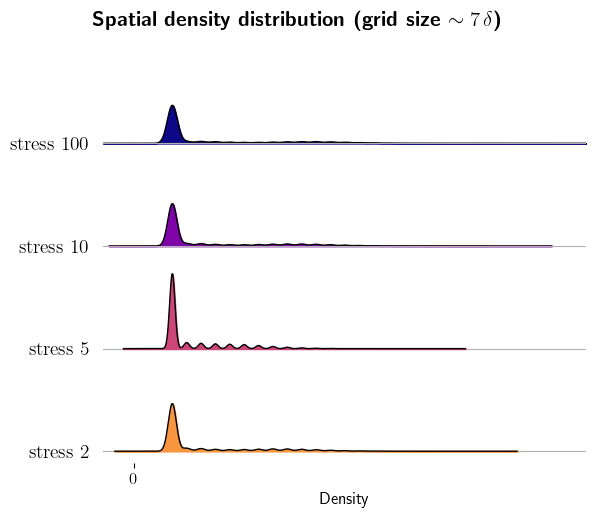

In [59]:
# Source - adapted from https://stackoverflow.com/a
# License - CC BY-SA 4.0

import joypy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

# Convert dictionary to long-format DataFrame
df_list = []
for stress_str, values in allMeshDensity.items():
    df_list.append(pd.DataFrame({'Density': values, 'StressStr': stress_str}))

df = pd.concat(df_list, ignore_index=True)

# Convert stress strings to numeric for sorting
df['StressNum'] = df['StressStr'].astype(float)

# Sort descending and create labels in LaTeX format
stress_order = sorted(df['StressNum'].unique(), reverse=True)
label_map = {s: rf"$\mathrm{{stress}} \; {{{int(s)}}}$" for s in stress_order}

# Map numeric stress to LaTeX labels
df['StressLabel'] = df['StressNum'].map(label_map)

# Ensure the labels are in the correct order
labels_ordered = [label_map[s] for s in stress_order]

# Create a high-DPI figure for crisp display
plt.figure(dpi=150)  # increase dpi for clear Jupyter view

fig, axes = joypy.joyplot(
    df,
    by="StressLabel",
    column="Density",
    labels=labels_ordered,
    range_style='own',
    grid="y",
    linewidth=1,
    legend=False,
    figsize=(6,5),
    colormap=cm.plasma,
    overlap=0.2
)

# Set title using Matplotlib
fig.suptitle(
    r"$\textbf{Spatial density distribution (grid size $\sim 7 \, \delta$)}$",
    fontsize=15,     # title font size
    fontweight='bold', # bold text
    y=1.02            # move slightly above the plot
)

# Set y-axis tick label size
for ax in fig.axes:
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')
    for tick in ax.get_xticklabels():
        tick.set_fontsize(12)
        tick.set_fontweight('bold')
    
# Set x-axis limits
plt.xlim(-0.2, 3)
plt.xlabel("Density", fontsize=12)

plt.ylabel("")  # no y-label because labels are on y-axis
plt.tight_layout()
plt.savefig(f'{figSavePath}/contPoints_density_stress_{stress}_.png', dpi=250, bbox_inches='tight')
plt.show()

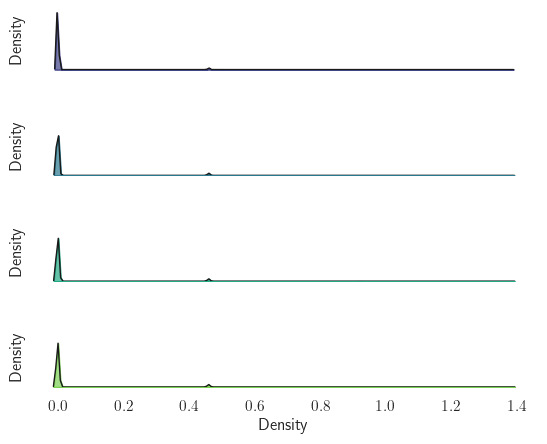

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Convert dictionary to a DataFrame for seaborn
df_list = []
for stress, values in allMeshDensity.items():
    df_list.append(pd.DataFrame({'Density': values, 'Stress': stress}))

df = pd.concat(df_list, ignore_index=True)

# Plot ridge plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid
g = sns.FacetGrid(df, row="Stress", hue="Stress", aspect=5, height=1.2, palette="viridis")

# Map the density plots
g.map(sns.kdeplot, "Density", fill=True, alpha=0.7)
g.map(sns.kdeplot, "Density", color="k", lw=1)

# Remove axes details
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.xlabel("Density")
plt.show()

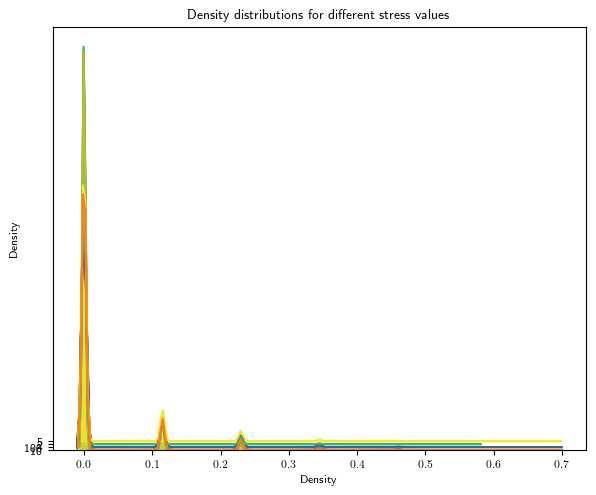

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# # Example dictionary: replace with your actual data
# allMeshDensity = {
#     0.1: np.random.normal(0, 1, 500),
#     0.2: np.random.normal(1, 1, 500),
#     0.3: np.random.normal(2, 1, 500)
# }

# Convert dictionary to long-format DataFrame
df_list = []
for stress, values in allMeshDensity.items():
    df_list.append(pd.DataFrame({'Density': values, 'Stress': stress}))
df = pd.concat(df_list, ignore_index=True)

# Convert stress to string for labels
df['Stress'] = df['Stress'].astype(str)

# Sort stress values so the ridges go bottom-to-top
stress_order = sorted(df['Stress'].unique())

# Set up the figure
plt.figure(figsize=(6, 5))

# Parameters for ridge spacing
n = len(stress_order)
offset = 1.2  # vertical offset between ridges

# Color map
colors = cm.viridis(np.linspace(0, 1, n))

# Plot each density as a ridge
for i, stress in enumerate(stress_order):
    subset = df[df['Stress'] == stress]['Density']
    # Use Seaborn KDE for smooth curve
    sns.kdeplot(subset, fill=True, alpha=0.7, color=colors[i], linewidth=1)
    plt.fill_betweenx([i*offset, i*offset], 0, 0, color=colors[i], alpha=0)  # shift vertically
    # Shift the KDE vertically
    x, y = subset.values, sns.kdeplot(subset).get_lines()[-1].get_ydata()
    plt.plot(sns.kdeplot(subset).get_lines()[-1].get_xdata(), y + i*offset, color=colors[i])
    plt.fill_between(sns.kdeplot(subset).get_lines()[-1].get_xdata(),
                     i*offset, y + i*offset, color=colors[i], alpha=0.7)

# Labels for each ridge
plt.yticks(np.arange(n)*offset, stress_order)
plt.xlabel("Density")
plt.title("Density distributions for different stress values")
plt.tight_layout()
plt.show()

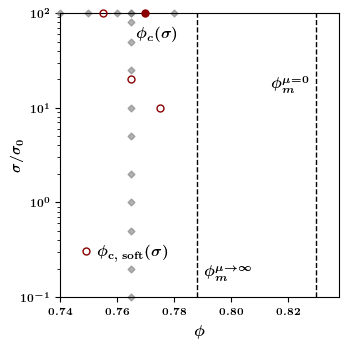

In [47]:
#Plotting available points for mapping onto flowtstae diagram

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

#aritra's data (gotten visually from his paper)
stress = [10, 20, 100]
phic   = [0.775, 0.765, 0.755]

# Plotting criticallity and jamming lines
page_width  = 7.05826  #inches
plt.figure(figsize=(page_width/2,page_width/2))

plt.xlim(0.74, 0.838)
plt.ylim(1e-1, 1e2)
plt.yscale('log')

plt.xlabel(r'$\phi$', fontsize=11, labelpad=6)          # fontsize + padding
plt.ylabel(r'$\sigma/ \sigma_0$', fontsize=10, labelpad=-2)

plt.xticks(fontsize=7.5)  # x-axis tick labels
plt.yticks(fontsize=8)  # y-axis tick labels

plt.axvline(0.788, color='k', linestyle='--', linewidth=1)
plt.axvline(0.83, color='k', linestyle='--', linewidth=1)
plt.plot(0.77, 100, 'o', color='darkred', markersize=5,
         zorder=5, clip_on=False) #, label=r'$\phi_c(\sigma)$')
plt.plot(phic, stress, 'o', mfc='none', mec='darkred', ms=5,
         zorder=5, clip_on=False, label=r'$\phi_{\mathrm{c,\; soft}}(\sigma)$')


## Plotting the available point inn stress and phi for \selta =1.4
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data'
stress_vals   = ['0.1','0.2','0.5','1','2','5','10','25','50','80','100'] # '0.05', '200','250'
phiv_vals     = [0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8, 0.802, 0.82] #.72
stress_floats = [float(st) for st in stress_vals]

for i, st in enumerate(stress_vals):
    for phi in phiv_vals:
        phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        path = f'{topDir}/flow_curves/stress_{st}r/NP_1000/phi_{phir}/ar_1.4/Vr_0.5/run_1'
        if os.path.exists(path):
            #print(path)
            plt.plot(phi, stress_floats[i], marker='D', linestyle='None', 
                     color='grey', markersize=3.5, alpha=0.6, zorder=2, clip_on=False)

## Plotting high stress phi data available
for phi in phiv_vals:
    phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
    path = f'{topDir}/NP_1000/phi_{phir}/ar_1.4/Vr_0.5/run_1'
    if os.path.exists(path):
        #print(path)
        plt.plot(phi, 100, marker='D', linestyle='None', 
                 color='grey', markersize=3.5, alpha=0.6, zorder=2, clip_on=False)
        
ax = plt.gca()
ax.set_yscale('log')
for spine in ax.spines.values():
    spine.set_zorder(2)
    
# Major ticks: powers of 10
ax.yaxis.set_major_locator(mticker.LogLocator(base=10))
ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext(base=10))

# Minor ticks: show dashes, no labels
ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto'))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())

plt.text(0.827, 22, r'$\phi^{\mu=0}_m$', fontsize=11, color='black', rotation=0, va='top', ha='right')
plt.text(0.807, 0.15, r'$\phi^{\mu\to \infty}_m$', fontsize=11, color='black', rotation=0, va='bottom', ha='right')
plt.text(0.7815, 51, r'$\phi_c(\sigma)$', fontsize=11, color='black', rotation=0, va='bottom', ha='right')
#plt.text(0.763, 48, r'$\phi_{c,\mathrm{soft}}$', fontsize=13, color='black', rotation=0, va='bottom', ha='right')

plt.legend(loc='lower left', bbox_to_anchor=(-0.01, 0.08), fontsize=11,
           frameon=False, handletextpad=-0.3)

plt.savefig(f'{figSavePath}/flowstate_marked.pdf', bbox_inches="tight", pad_inches=0.03, dpi=600, transparent=True)
plt.show()

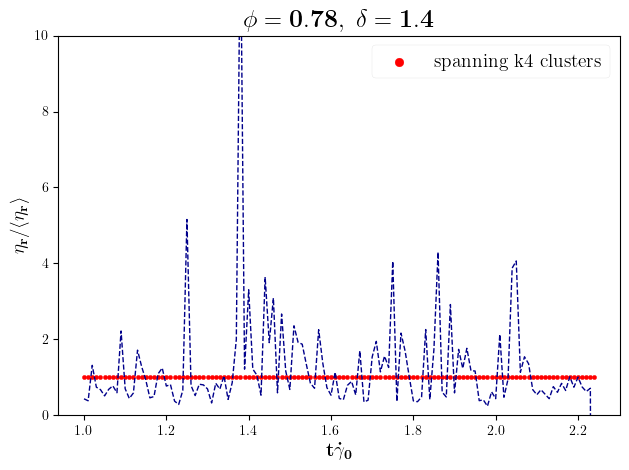

In [388]:
datFile = glob.glob(f'{dataname}/data_*.dat')[0]
data    = np.loadtxt(open(datFile))
visc    = data[off:off+300, 3]
strain  = data[off:off+300, 1]

plt.plot(strain, visc/np.mean(visc), color='darkblue', linestyle='--', linewidth=1)
plt.scatter(np.array(list(kspanning))/100, np.ones(len(list(kspanning))), color='red', s=10,
           label='spanning k4 clusters') #rig clusters

plt.legend(fontsize=14, markerscale=2.0,)
plt.xlabel(r'$\mathbf{t \dot \gamma_0}$',fontsize=14)
plt.ylabel(r'$\mathbf{\eta_r/\langle \eta_r \rangle}$',fontsize=14)
plt.title(fr'$\mathbf{{\phi = {phi}, \; \delta = {ar}}}$',fontsize=18)
#plt.yscale('log')
plt.ylim([0, 10])
plt.savefig(f'{figSavePath}/spanning_k3_phi_{phi}_ar_{ar}.pdf', dpi=400)

plt.show()

In [91]:
## When percolation first appers in phi sweep

phim = np.array([[0.787, 0.788, 0.794 , 0.828],
                  [0.787, 0.787, 0.798 , 0.826],
                  [0.787, 0.787, 0.792, 0.807]])

# Simulation parameters.
npp      = 1000
phi      = [0.71, 0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8, 0.802, 0.82]
ar       = [1.0, 1.4, 2.0, 4.0]
vr       = ['0.25', '0.5', '0.75']
numRuns  = 2
off      = 100

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

print('When does the first percolation occur in packing fraction (phi and phim):')

for k in range(len(ar)):
    print('\n')
    for l in range(len(vr)):
        stop_outer = False
        for j in range(len(phi)):
            if stop_outer:
                break 
                
            phii = phi[j]
            phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
            for m in range(numRuns):
                dataname = topDir / f"NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{m+1}"
                if os.path.exists(dataname):
                    particleFile  = open(glob.glob(f'{dataname}/{parFile}')[0])
                    parLines      = particleFile.readlines()
                    particlesList = readFiles.readParFile(particleFile)
        
                    rigFilePath   = glob.glob(f'{dataname}/{rigFile}')
                    if not rigFilePath:
                        print(f"Error: {rigFile} not found at {dataname}")
                        sys.exit(1)
                    rigidFile     = open(rigFilePath[0])
                    rigClusterIDs = readFiles.rigList(rigidFile)
                    
                    # Box dimensions.
                    Lx = float(parLines[3].split()[2]) 
                    Lz = float(parLines[3].split()[2])
        
                    #for frame in tqdm(range(off, len(particlesList)), desc="Inner loop", leave=False):
                    for frame in range(off, len(particlesList)):
                        #print(frame)
                        px = particlesList[frame][:,2]
                        pz = particlesList[frame][:,3]
                        pr = particlesList[frame][:,1]
        
                        for rigpart in rigClusterIDs[frame]:
                            posx = px[rigpart]
                            posz = pz[rigpart]
                            
                            span = periodic_cluster_span(posz, Lz)
                            #spanlist.append(span)
                            if span >= Lz - ar[k]:
                                print(f'ar = {ar[k]}, vr = {vr[l]}, run = {m+1} --> {phii}, {(float(phii)/phim[l][k]):.4f}')
                                stop_outer = True
                                break 
                                
                        if stop_outer:
                            break

When does the first percolation occur in packing fraction (phi and phim):


ar = 1.0, vr = 0.25, run = 1 --> 0.76, 0.9657
ar = 1.0, vr = 0.5, run = 1 --> 0.76, 0.9657
ar = 1.0, vr = 0.75, run = 1 --> 0.76, 0.9657


ar = 1.4, vr = 0.25, run = 1 --> 0.76, 0.9645
ar = 1.4, vr = 0.5, run = 1 --> 0.76, 0.9657
ar = 1.4, vr = 0.75, run = 1 --> 0.76, 0.9657


ar = 2.0, vr = 0.25, run = 1 --> 0.76, 0.9572
ar = 2.0, vr = 0.5, run = 2 --> 0.76, 0.9524
ar = 2.0, vr = 0.75, run = 1 --> 0.76, 0.9596


ar = 4.0, vr = 0.25, run = 1 --> 0.785, 0.9481
ar = 4.0, vr = 0.5, run = 1 --> 0.785, 0.9504
ar = 4.0, vr = 0.75, run = 1 --> 0.77, 0.9542


In [89]:
phii

'0.76'

In [75]:
## Identify percolating rig clusters

# Simulation parameters.
npp     = 1000
phi     = [0.76] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar      = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr      = ['0.5']
numRun  = 1
off     = 100

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = topDir / f"NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}"
            if os.path.exists(dataname):
                particleFile  = open(glob.glob(f'{dataname}/run_{numRun}/{parFile}')[0])
                parLines      = particleFile.readlines()
                particlesList = readFiles.readParFile(particleFile)

                rigFilePath   = glob.glob(f'{dataname}/run_{numRun}/{rigFile}')
                if not rigFilePath:
                    print(f"Error: {rigFile} not found at {dataname}/run_{numRun}")
                    sys.exit(1)
                rigidFile     = open(rigFilePath[0])
                rigClusterIDs = readFiles.rigList(rigidFile)
                
                # Box dimensions.
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                percframes = [] 
                #spanlist = []
                for frame in tqdm(range(off, len(particlesList)), desc="Inner loop", leave=False):
                    #print(frame)
                    px = particlesList[frame][:,2]
                    pz = particlesList[frame][:,3]
                    pr = particlesList[frame][:,1]

                    for rigpart in rigClusterIDs[frame]:
                        posx = px[rigpart]
                        posz = pz[rigpart]
                        
                        span = periodic_cluster_span(posz, Lz)
                        #spanlist.append(span)
                        if span >= Lz - ar[k]:
                            percframes.append(frame)

# show frames with percolating rig clusters
np.array(percframes)